
# Pipeline e Análises — Jogos Olímpicos (1896–2024)

Este notebook automatiza a criação do Data Lake (raw→bronze→gold) e responde às perguntas:

1. Evolução da distribuição de medalhas por país (1986–Paris 2024)
2. Modalidades com maior crescimento de participantes (1986–2024)
3. Evolução da proporção de atletas por sexo nas principais modalidades até Paris 2024

**Como usar**: Baixe os CSVs das fontes e coloque-os em `raw/` com nomes:
- `olympics_historico.csv`
- `olympics_paris2024.csv`

Em seguida execute as células abaixo (localmente) — o notebook criará `bronze/` e `gold/`.


In [1]:
! pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Setup: import libs, paths e função utilitárias
import os, json, pandas as pd, numpy as np
from pathlib import Path
root = Path('.') / 'D:'
raw = root / 'raw'
bronze = root / 'bronze'
gold = root / 'gold'
raw.mkdir(parents=True, exist_ok=True)
bronze.mkdir(parents=True, exist_ok=True)
gold.mkdir(parents=True, exist_ok=True)
print('Diretórios prontos em', root.resolve())

def save_json_metadata(path, meta_dict):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(meta_dict, f, indent=2, ensure_ascii=False)


Diretórios prontos em D:\olympics-datalake


In [3]:
#Pré Processamento: Associar os csvs medallists e athletes do dataset de Paris

# Caminhos dos arquivos de entrada
output_path = raw / "olympics_paris2024"
athletes_path = raw / "olympics_paris_athlete.csv"
medallists_path = raw / "olympics_paris_medalhistas.csv"

athletes = pd.read_csv(athletes_path, low_memory=False)
med = pd.read_csv(medallists_path, low_memory=False)

sep = "; "
# Verificações básicas
if 'code' not in athletes.columns:
    raise KeyError("Coluna 'code' não encontrada em athletes.csv")
if 'code_athlete' not in med.columns:
    raise KeyError("Coluna 'code_athlete' não encontrada em medallists.csv")

# Normalizar identificadores como string (evita mismatch por inteiros/strings)
athletes['code'] = athletes['code'].astype(str).str.strip()
med['code_athlete'] = med['code_athlete'].astype(str).str.strip()

# Contagem de medalhas por atleta
medal_count = med.groupby('code_athlete').size().rename('medal_count')

# Escolher colunas de medallists para agregar:
# pegamos todas exceto 'code_athlete' e exceto colunas que também existem em athletes
cols_to_agg = [c for c in med.columns if c != 'code_athlete' and c not in athletes.columns]

# Construir DataFrame agregado iniciando com medal_count
agg_df = medal_count.to_frame()

# Para cada coluna selecionada, agregar valores únicos como string separada por sep
for c in cols_to_agg:
    # converte para string e remove NaNs antes de unir
    s = med.groupby('code_athlete')[c].apply(
        lambda x: sep.join(x.dropna().astype(str).unique()) if x.dropna().any() else ""
    )
    agg_df = agg_df.join(s)

# Prefixar as colunas agregadas com 'medal_' para evitar colisão de nomes
rename_map = {}
for col in agg_df.columns:
    if col != 'medal_count':
        rename_map[col] = f"medal_{col}"
agg_df = agg_df.rename(columns=rename_map)

# Garantir medal_count como inteiro e preencher missing com 0
agg_df['medal_count'] = agg_df['medal_count'].fillna(0).astype(int)

# Merge (left) — manter todos os atletas
result = athletes.merge(agg_df, left_on='code', right_index=True, how='left')

# Preencher atletas sem medalhas: medal_count 0 e campos medal_* vazios
if 'medal_count' not in result.columns:
    result['medal_count'] = 0
result['medal_count'] = result['medal_count'].fillna(0).astype(int)

for c in result.columns:
    if c.startswith('medal_') and c != 'medal_count':
        result[c] = result[c].fillna("")

# Adicionar coluna fixa year = 2024
result['year'] = 2024

result["medal_medal_type"] = result["medal_medal_type"].str.strip()

result["medal_medal_type"] = result["medal_medal_type"].str.replace(" Medal", "", regex=False)

# Salvar CSV final
result.to_csv(output_path, index=False)

print(f"Concluído. Arquivo salvo em: {output_path}")
print(f"Linhas no resultado: {len(result)}")
print("Colunas adicionadas (prefixo medal_):",
        [c for c in result.columns if c.startswith('medal_')])

Concluído. Arquivo salvo em: D:raw\olympics_paris2024
Linhas no resultado: 11113
Colunas adicionadas (prefixo medal_): ['medal_count', 'medal_medal_date', 'medal_medal_type', 'medal_medal_code', 'medal_team', 'medal_team_gender', 'medal_discipline', 'medal_event', 'medal_event_type', 'medal_url_event', 'medal_code_team', 'medal_is_medallist']


In [4]:
#Pré Processamento: Associar os csvs bio com o historico

# Caminhos dos arquivos de entrada
output_path = raw / "olympics_historico"
historico_path = raw / "olympics_historico_athleteresult.csv"
bio_path = raw / "olympics_historico_bio.csv"

athletes = pd.read_csv(historico_path, low_memory=False)
bio = pd.read_csv(bio_path, low_memory=False)

olympics_historico = athletes.merge(
    bio[['athlete_id', 'sex']],  # apenas colunas necessárias
    on="athlete_id",
    how="left"  # mantém todos do histórico
)

olympics_historico["edition"] = olympics_historico["edition"].str.extract(r"(\d{4})")

olympics_historico['medal_count'] = olympics_historico['medal'].notna().astype(int)

olympics_historico.to_csv(output_path, index=False)
print("Arquivo salvo: olympics_historico.csv")

Arquivo salvo: olympics_historico.csv


In [5]:
# 1) Carregar os arquivos brutos (usuário deve colocar os CSVs em raw/)
hist_path = raw / 'olympics_historico'
paris_path = raw / 'olympics_paris2024'

if not hist_path.exists() or not paris_path.exists():
    print('ERRO: coloque os CSVs em raw/ com os nomes: olympics_historico.csv e olympics_paris2024.csv')
else:
    df_hist = pd.read_csv(hist_path, low_memory=False)
    df_paris = pd.read_csv(paris_path, low_memory=False)
    print('Arquivos carregados: historico:', df_hist.shape, 'paris2024:', df_paris.shape)


Arquivos carregados: historico: (316834, 13) paris2024: (11113, 49)


In [6]:

# 2) Limpeza básica e harmonização de colunas
def harmonize(df):
    df = df.copy()
    # padronizar nomes de colunas comuns
    colmap = {}
    for c in df.columns:
        lc = c.strip().lower()
        if lc in ['year','edition','season']:
            colmap[c] = 'year'
        if lc in ['city','host_city']:
            colmap[c] = 'city'
        if lc in ['sport','sports']:
            colmap[c] = 'sport'
        if lc in ['event','event_name', 'medal_events']:
            colmap[c] = 'event'
        if lc in ['athlete','name']:
            colmap[c] = 'athlete'
        if lc in ['country','nation','noc','team']:
            colmap[c] = 'country'
        if lc in ['medal','medals']:
            colmap[c] = 'medal'
        if lc in ['sex','gender']:
            colmap[c] = 'sex'
    df = df.rename(columns=colmap)
    # keep essential columns if exist
    expected = ['year','city','sport','event','athlete','country','medal','sex']
    for e in expected:
        if e not in df.columns:
            df[e] = pd.NA
    # normalize year to int where possible
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    # standardize sex values
    df['sex'] = df['sex'].astype('string').str.upper().replace({'M':'M','F':'F','MALE':'M','FEMALE':'F'})

    # trim strings
    strcols = ['city','sport','event','athlete','country','medal','sex']
    for c in strcols:
        if c in df.columns:
            df[c] = df[c].astype('string').str.strip()
    return df

# Apply harmonization if files exist
if 'df_hist' in globals():
    df_hist = harmonize(df_hist)
    df_paris = harmonize(df_paris)
    print('Harmonização concluída. Exemplo colunas:', df_hist.columns.tolist())


Harmonização concluída. Exemplo colunas: ['year', 'edition_id', 'country_noc', 'sport', 'event', 'result_id', 'athlete', 'athlete_id', 'position', 'medal', 'is_team_sport', 'sex', 'medal_count', 'city', 'country']


In [7]:
df_hist

,year,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,position,medal,is_team_sport,sex,medal_count,city,country
0,1928,30,SUI,Skeleton,"Skeleton, Men",1,Willy von Eschen,98710,Did not finish,<NA>,False,M,0,<NA>,<NA>
1,1928,30,FRA,Skeleton,"Skeleton, Men",1,"Jean, Comte de Beaumont",42118,Did not start,<NA>,False,M,0,<NA>,<NA>
2,1928,30,FRA,Skeleton,"Skeleton, Men",1,Pierre Dormeuil,85267,Did not finish,<NA>,False,M,0,<NA>,<NA>
3,1928,30,GBR,Skeleton,"Skeleton, Men",1,Lord Brabazon of Tara,1202561,Did not start,<NA>,False,M,0,<NA>,<NA>
4,1928,30,SUI,Skeleton,"Skeleton, Men",1,Alexander Berner,84063,5,<NA>,False,M,0,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316829,2022,62,ESP,Snowboarding,"Halfpipe, Women",19020782,Queralt Castellet,109979,2,Silver,False,F,1,<NA>,<NA>
316830,2022,62,FRA,Snowboarding,"Cross, Women",19020790,Chloé Trespeuch,127764,2,Silver,False,F,1,<NA>,<NA>
316831,2022,62,NZL,Snowboarding,"Big Air, Women",19020805,Zoi Sadowski-Synnott,137770,2,Silver,False,F,1,<NA>,<NA>
316832,2022,62,ITA,Snowboarding,"Team Cross, Mixed",19020813,Michela Moioli,127953,2,Silver,True,F,1,<NA>,<NA>


In [8]:
df_paris['medal'].unique()

<StringArray>
[<NA>]
Length: 1, dtype: string

In [9]:
import pyarrow

# 3) Salvar como Parquet na pasta bronze/ e gerar metadados
def save_parquet_and_meta(df, out_path, meta):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(out_path, index=False)
    save_json_metadata(str(out_path.with_suffix('.json')), meta)

if 'df_hist' in globals():
    save_parquet_and_meta(df_hist, bronze / 'olympics_historico.parquet', {
        'dataset_name':'olympics_historico',
        'source':'Base dos Dados - Historical Data from the Olympics',
        'rows': int(df_hist.shape[0]),
        'columns': list(df_hist.columns),
        'collection_date':'2025-09-20'
    })
    save_parquet_and_meta(df_paris, bronze / 'olympics_paris2024.parquet', {
        'dataset_name':'olympics_paris2024',
        'source':'Kaggle - Paris 2024',
        'rows': int(df_paris.shape[0]),
        'columns': list(df_paris.columns),
        'collection_date':'2025-09-20'
    })
    print('Parquet salvos em bronze/')


Parquet salvos em bronze/


In [10]:

# 4) Integração: unir as duas fontes (foco em anos >= 1986 até 2024)
# Base dos Dados já tem a coluna year (garantir que seja int)
if 'df_hist' in globals():
    df_hist['year'] = pd.to_numeric(df_hist['year'], errors='coerce').astype('Int64')

# Paris 2024: criar a coluna year = 2024
if 'df_paris' in globals():
    df_paris['year'] = 2024
    df_paris['year'] = df_paris['year'].astype('Int64')

# Integração
df_all = pd.concat([df_hist, df_paris], ignore_index=True, sort=False)

# Filtrar anos válidos
df_all = df_all[df_all['year'].notna()]
df_all['year'] = df_all['year'].astype(int)
df_all = df_all[(df_all['year'] >= 1986) & (df_all['year'] <= 2024)]

print('Integração pronta, linhas:', df_all.shape[0])
df_all.to_parquet(bronze / 'olympics_1986_2024.parquet', index=False)
save_json_metadata(str((bronze / 'olympics_1986_2024').with_suffix('.json')), {
    'dataset_name':'olympics_1986_2024',
    'source':'concat(base_dos_dados, kaggle_paris2024)',
    'rows': int(df_all.shape[0]),
    'columns': list(df_all.columns),
    'notes':'Filtrado para anos 1986-2024'
})

Integração pronta, linhas: 177633


In [11]:
# 5) Análises pedidas
import matplotlib.pyplot as plt
%matplotlib inline

# criar pasta gold se nao existir
(gold / 'analise_medalhas').mkdir(parents=True, exist_ok=True)
(gold / 'analise_modalidades').mkdir(parents=True, exist_ok=True)
(gold / 'analise_genero').mkdir(parents=True, exist_ok=True)


C:\Users\Alien\AppData\Local\Temp\ipykernel_31824\2438399902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medals['medal_normalized'] = df_medals['medal'].astype('string').str.lower()


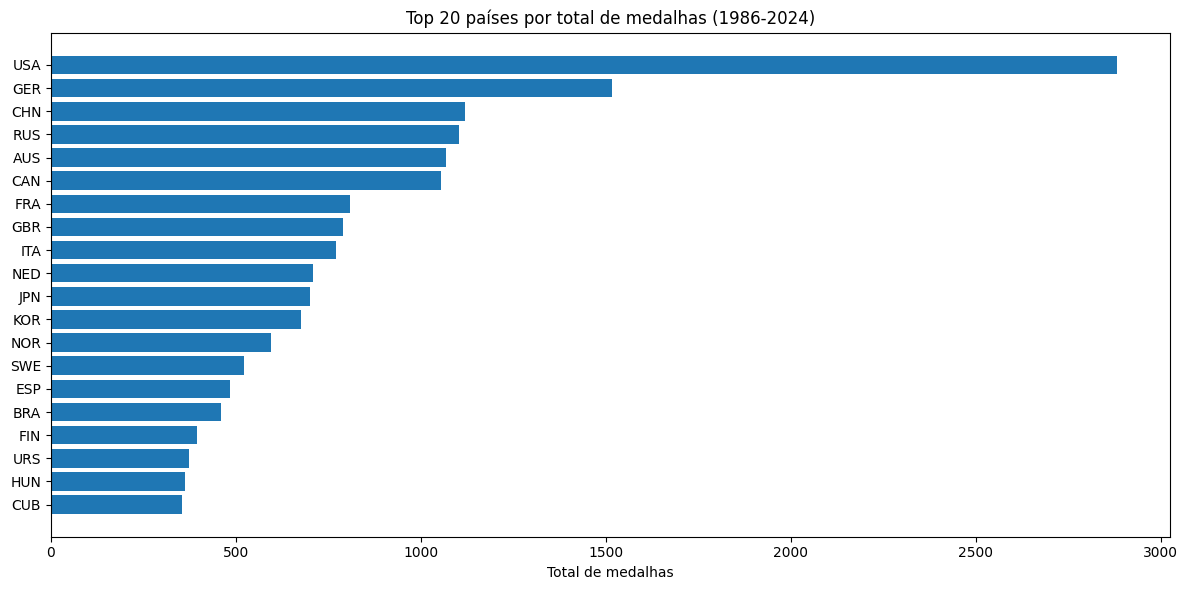

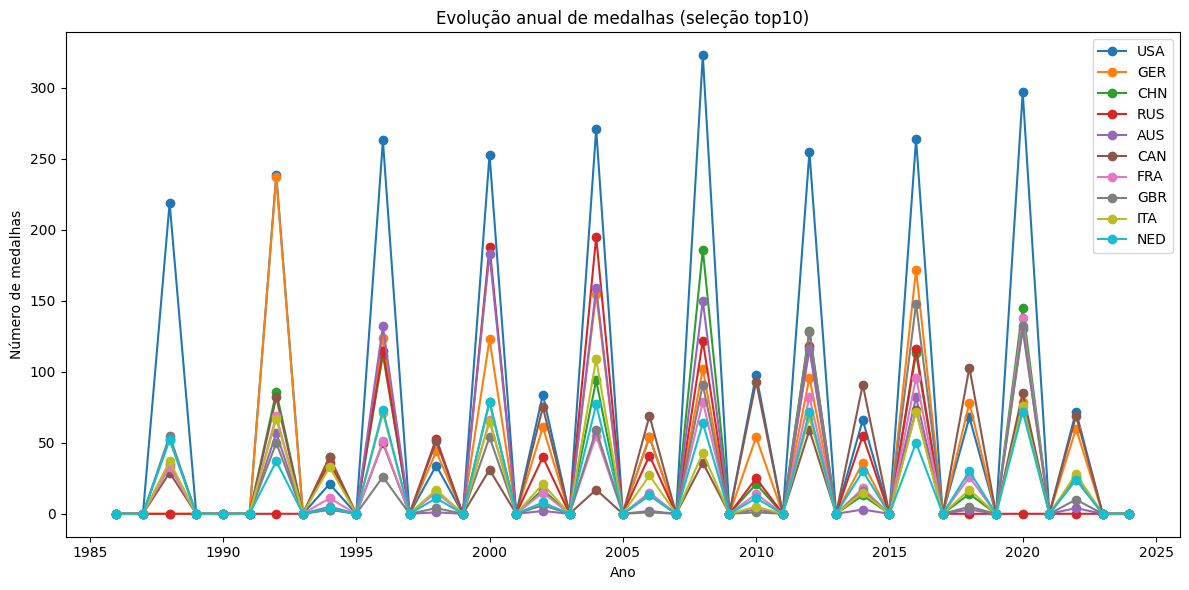

In [13]:

# --- Pergunta 1: Evolução da distribuição de medalhas por país desde 1986 até Paris 2024
# Assumimos que a coluna 'medal' contém nome da medalha (Gold/Silver/Bronze/NA)
df_medals = df_all[df_all['medal'].notna() & (df_all['medal']!='')]
# normalizar medal names
df_medals['medal_normalized'] = df_medals['medal'].astype('string').str.lower()
# contador por país e edição
medals_by_country_year = df_medals.groupby(['year','country_noc']).size().reset_index(name='medal_count')
# total por país (1986-2024)
total_by_country = medals_by_country_year.groupby('country_noc')['medal_count'].sum().reset_index().sort_values('medal_count', ascending=False)
# média por edição
mean_by_country = medals_by_country_year.groupby('country_noc')['medal_count'].mean().reset_index().sort_values('medal_count', ascending=False)
# salvar tabelas
total_by_country.to_csv(gold / 'analise_medalhas' / 'medalhas_total_por_pais_1986_2024.csv', index=False)
mean_by_country.to_csv(gold / 'analise_medalhas' / 'medalhas_media_por_edicao_por_pais.csv', index=False)

# Plot: top 20 países por total de medalhas (barra)
top20 = total_by_country.head(20)
plt.figure(figsize=(12,6))
plt.barh(top20['country_noc'][::-1], top20['medal_count'][::-1])
plt.title('Top 20 países por total de medalhas (1986-2024)')
plt.xlabel('Total de medalhas')
plt.tight_layout()
plt.savefig(gold / 'analise_medalhas' / 'medalhas_top20_total_1986_2024.png')
plt.show()

# Série temporal: medalhas por país (exemplo para top 6 países)
top10 = top20['country_noc'].head(10).tolist()
plt.figure(figsize=(12,6))
for c in top10:
    series = medals_by_country_year[medals_by_country_year['country_noc']==c].set_index('year').reindex(range(1986,2025), fill_value=0)['medal_count']
    plt.plot(series.index, series.values, marker='o', label=c)
plt.legend()
plt.title('Evolução anual de medalhas (seleção top10)')
plt.xlabel('Ano')
plt.ylabel('Número de medalhas')
plt.tight_layout()
plt.savefig(gold / 'analise_medalhas' / 'medalhas_evolucao_top6.png')
plt.show()


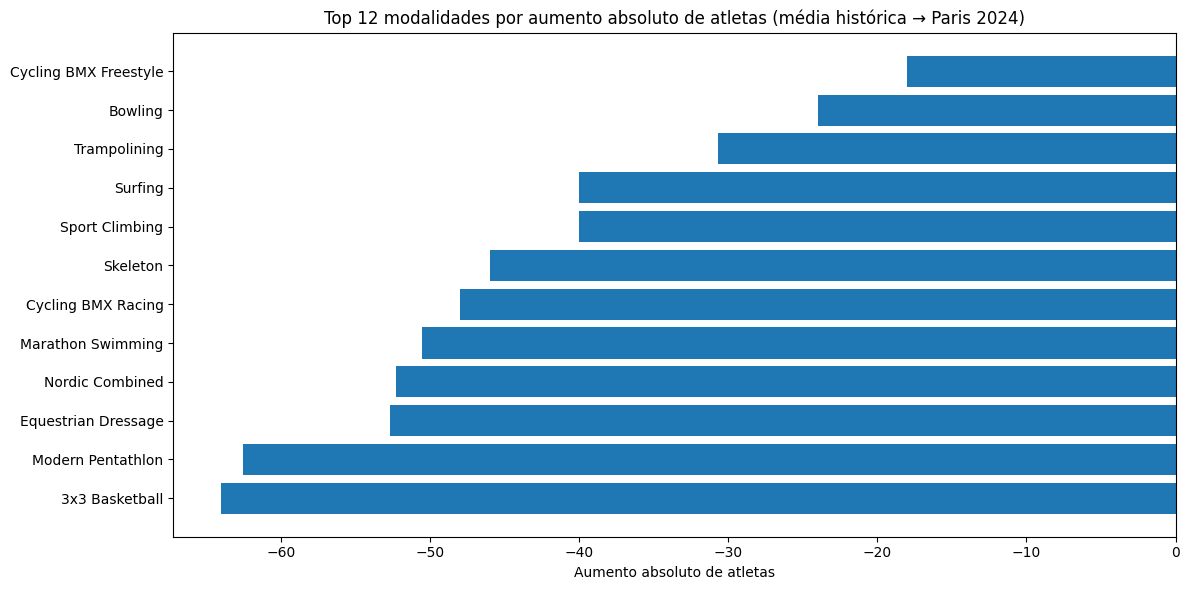

In [20]:

# --- Pergunta 2: Modalidades que mais cresceram em número de participantes entre 1986 e 2024
# Precisamos de uma coluna que represente participação. Muitas bases têm 'athlete' ou 'participants'.
# Vamos contar atletas únicos por esporte e edição.
cresc = 0

participants = df_all[df_all['athlete'].notna()]
participants_unique = participants.groupby(['year','sport'])['athlete'].nunique().reset_index(name='n_athletes')
# média histórica por esporte (1986-2022) vs Paris 2024
mean_historical = participants_unique[participants_unique['year']<2024].groupby('sport')['n_athletes'].mean().reset_index(name='mean_historical')
paris2024 = participants_unique[participants_unique['year']==2024][['sport','n_athletes']].rename(columns={'n_athletes':'paris_2024'})
modalities_growth = mean_historical.merge(paris2024, on='sport', how='left').fillna(0)

if (cresc == 1):
    modalities_growth['absolute_change'] = -modalities_growth['paris_2024'] - modalities_growth['mean_historical']
else:
    modalities_growth['absolute_change'] = modalities_growth['paris_2024'] - modalities_growth['mean_historical'] 
    
modalities_growth['absolute_change'] = modalities_growth['paris_2024'] - modalities_growth['mean_historical']
modalities_growth['relative_change_pct'] = modalities_growth['absolute_change'] / modalities_growth['mean_historical'].replace(0, np.nan) * 100
modalities_growth = modalities_growth.sort_values('absolute_change', ascending=False)
modalities_growth.to_csv(gold / 'analise_modalidades' / 'modalidades_crescimento_1986_2024.csv', index=False)

# Estatísticas: moda/mediana do número de participantes (histórico)
modal_stats = participants_unique.groupby('sport')['n_athletes'].agg(['median', lambda x: x.mode().iat[0] if not x.mode().empty else pd.NA]).reset_index()
modal_stats.columns = ['sport','median_historical','mode_historical']
modal_stats.to_csv(gold / 'analise_modalidades' / 'modal_stats.csv', index=False)

# Plot: top 12 modalidades por crescimento absoluto
top12 = modalities_growth.head(12)
plt.figure(figsize=(12,6))
plt.barh(top12['sport'][::-1], top12['absolute_change'][::-1])
plt.title('Top 12 modalidades por aumento absoluto de atletas (média histórica → Paris 2024)')
plt.xlabel('Aumento absoluto de atletas')
plt.tight_layout()
plt.savefig(gold / 'analise_modalidades' / 'modalidades_top12_crescimento.png')
plt.show()


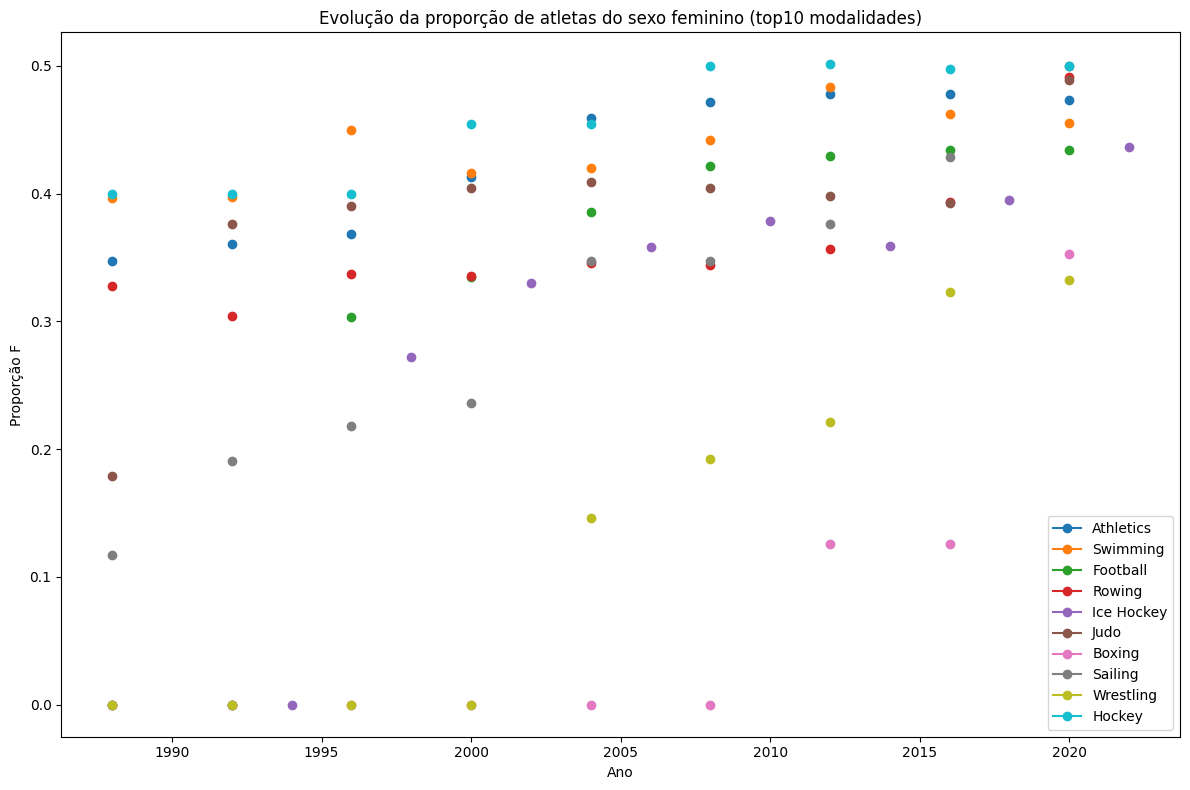

C:\Users\Alien\AppData\Local\Temp\ipykernel_36424\1416717501.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_sports, vert=False)


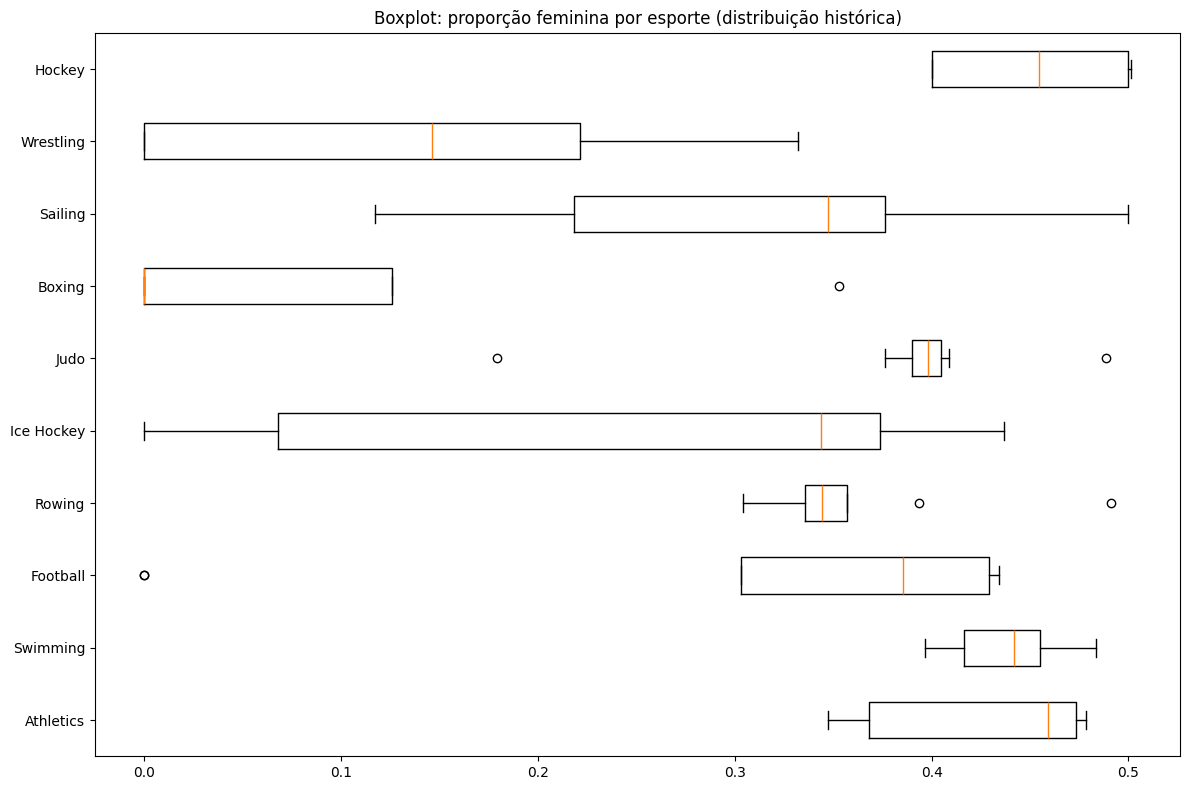

In [ ]:

# --- Pergunta 3: Evolução da proporção de atletas por sexo nas principais modalidades até Paris 2024
# Calcular proporção por sexo e edição para os top modalidades por número total de atletas
df_sex = df_all[df_all['sex'].notna() & df_all['athlete'].notna()]
sex_counts = df_sex.groupby(['year','sport','sex'])['athlete'].nunique().reset_index(name='n_athletes')
# pivot para proporção
pivot = sex_counts.pivot_table(index=['year','sport'], columns='sex', values='n_athletes', fill_value=0).reset_index()
# calcular proporção de F em relação ao total
if 'F' in pivot.columns and 'M' in pivot.columns:
    pivot['prop_f'] = pivot['F'] / (pivot['F'] + pivot['M'])
else:
    pivot['prop_f'] = pivot.get('F', 0) / (pivot.get('F', 0) + pivot.get('M', 0))

# escolher top modalidades por soma de atletas 1986-2024
top_sports = df_sex.groupby('sport')['athlete'].nunique().reset_index(name='total_athletes').sort_values('total_athletes', ascending=False).head(10)['sport'].tolist()

# plot evolution of prop_f for top sports
plt.figure(figsize=(12,8))
for s in top_sports:
    series = pivot[pivot['sport']==s].set_index('year').reindex(range(1986,2025))['prop_f']
    plt.plot(series.index, series.values, marker='o', label=s)
plt.legend()
plt.title('Evolução da proporção de atletas do sexo feminino (top10 modalidades)')
plt.xlabel('Ano')
plt.ylabel('Proporção F')
plt.tight_layout()
plt.savefig(gold / 'analise_genero' / 'prop_feminina_top10_modalidades.png')
plt.show()

# Boxplots: distribuição de proporção por esporte (usar dados até 2024)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
data = [pivot[pivot['sport']==s]['prop_f'].dropna() for s in top_sports]
plt.boxplot(data, labels=top_sports, vert=False)
plt.title('Boxplot: proporção feminina por esporte (distribuição histórica)')
plt.tight_layout()
plt.savefig(gold / 'analise_genero' / 'boxplot_prop_feminina_top10.png')
plt.show()

# salvar tabelas resumo
pivot.to_csv(gold / 'analise_genero' / 'proporcao_sexo_por_ano_e_sport.csv', index=False)


In [ ]:

# 6) Metadados finais para gold/
final_meta = {
    'analise_medalhas':{'file':'medalhas_total_por_pais_1986_2024.csv','description':'Tabelas e gráficos de medalhas por país (1986-2024)'},
    'analise_modalidades':{'file':'modalidades_crescimento_1986_2024.csv','description':'Crescimento de participantes por modalidade'},
    'analise_genero':{'file':'proporcao_sexo_por_ano_e_sport.csv','description':'Proporção de atletas por sexo por esporte e ano'}
}
with open(gold / 'metadata_summary.json','w',encoding='utf-8') as f:
    json.dump(final_meta, f, indent=2, ensure_ascii=False)
print('Pipeline concluído. Verifique a pasta gold/ para outputs e gráficos.')


Pipeline concluído. Verifique a pasta gold/ para outputs e gráficos.
